## Comparing dbt-spark vs dbt-databricks memory use

Reproducing `dbt-databricks` adapter consuming more memory for the same operation than `dbt-spark`. 

> Note: Before running the tests steps below, I created a brand new schema `dbt_jyeo_performance` in the `hive_metastore` catalog so as to not use a schema with existing tables already. 
> We're also running with a singular toy model `select 1 id` for now.

1. Install docker.

2. Install Python requirements.

```sh
python -m venv venv
source venv/bin/activate
pip install --upgrade pip
pip install -r requirements.txt
```

3. Activate `jupyter-lab` and open `README.ipynb` and start running cells.

In [1]:
import os
import subprocess
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import altair as alt
alt.renderers.enable('mimetype') # required for charts in GitHub notebook renders.
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

4. Build our various docker images.

In [2]:
subprocess.Popen(f"docker build --quiet -t dbt_spark_13 . -f Dockerfile.spark_13", shell=True).wait()
subprocess.Popen(f"docker build --quiet -t dbt_spark_14 . -f Dockerfile.spark_14", shell=True).wait()
subprocess.Popen(f"docker build --quiet -t dbt_databricks_13 . -f Dockerfile.databricks_13", shell=True).wait()
subprocess.Popen(f"docker build --quiet -t dbt_databricks_14 . -f Dockerfile.databricks_14", shell=True).wait()

sha256:75a99b24f3d5f4004e7f571dcb48e0fdc9ba04678d0627026b1e9dde8dbf0d84
sha256:21c247e5b1669f8bf77ae1efae8ae4abc68a03d8f9b90754788130a450e5959f
sha256:7dace5b4a4cbb99fb22cca4cd6b431e43d1281889140322067fb10da6305ff8c
sha256:aadf790debd32f4ac1ef93007b42825522452b4d2ec65e14d97c410f1766348c


0

5. Create `.env` file with the following env vars:

```sh
DBT_SCHEMA=<schema-you-want-to-use>
DBT_HOST=<databricks-account-hostname>
DBT_TOKEN=<databricks-token>
DBT_ENDPOINT=<databricks-sql-endpoint>
```

> These will be passed to the docker container when it runs so that dbt inside the container can connect to databricks.

In [3]:
cwd = os.getcwd()

def read_mprof_file(filename, iteration):
    mem_usage = []
    timestamp = []
    with open(filename, "r") as f:
        for l in f:
            field, value = l.split(" ", 1)
            if field == "MEM":
                values = value.split(" ")
                mem_usage.append(float(values[0]))
                timestamp.append(float(values[1]))
    return {"mem_usage": mem_usage, "timestamp": timestamp, "iteration": iteration}

In [4]:
# SQL endpoints take a bit of time to start from a cold start so we're doing a quick debug to make sure it's started before we run the rest of the commands.
subprocess.Popen(f"docker run --env-file .env -t --rm -v {cwd}/dbt:/app dbt_spark_14 dbt debug", shell=True).wait()
print("SQL endpoint started")

08:36:09  Running with dbt=1.4.6
dbt version: 1.4.6
python version: 3.9.16
python path: /usr/local/bin/python
os info: Linux-5.15.49-linuxkit-x86_64-with-glibc2.31
Using profiles.yml file at /app/profiles.yml
Using dbt_project.yml file at /app/dbt_project.yml

Configuration:
  profiles.yml file [OK found and valid]
  dbt_project.yml file [OK found and valid]

Required dependencies:
 - git [OK found]

Connection:
  host: dbc-c7c89cba-cf9b.cloud.databricks.com
  port: 443
  cluster: None
  endpoint: 8bce9401ba8e2755
  schema: dbt_jyeo_perf_testing
  organization: 0
  Connection test: [OK connection ok]

All checks passed!
SQL endpoint started


6. Invoke dbt multiple times and draw plots.

## 1.3.latest

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.


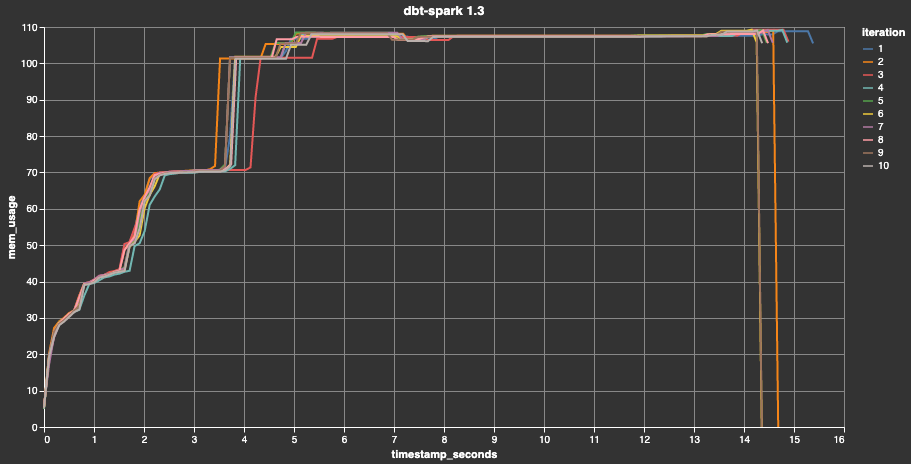

In [5]:
df = pd.DataFrame(columns=["mem_usage", "timestamp", "timestamp_seconds", "iteration"])

for _ in range(10):
    if os.path.exists(f"{cwd}/dbt/data.dat"):
        os.remove(f"{cwd}/dbt/data.dat")

    cmd = f"docker run --env-file .env -t --rm -v {cwd}/dbt:/app dbt_spark_13 mprof run --output data.dat dbt run"
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.DEVNULL)
    p.wait()
    print(f"Run {_ + 1} completed.")
    raw = read_mprof_file(f"{cwd}/dbt/data.dat", iteration = _ + 1)
    raw_df = pd.DataFrame.from_dict(raw)
    raw_df["timestamp_seconds"] = raw_df["timestamp"] - raw_df["timestamp"][0]
    df = pd.concat([df, raw_df])

alt.Chart(df).mark_line().encode(
    x="timestamp_seconds", y="mem_usage", color="iteration:N"
).properties(
    width=800, height=400, title="dbt-spark 1.3"
)

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.


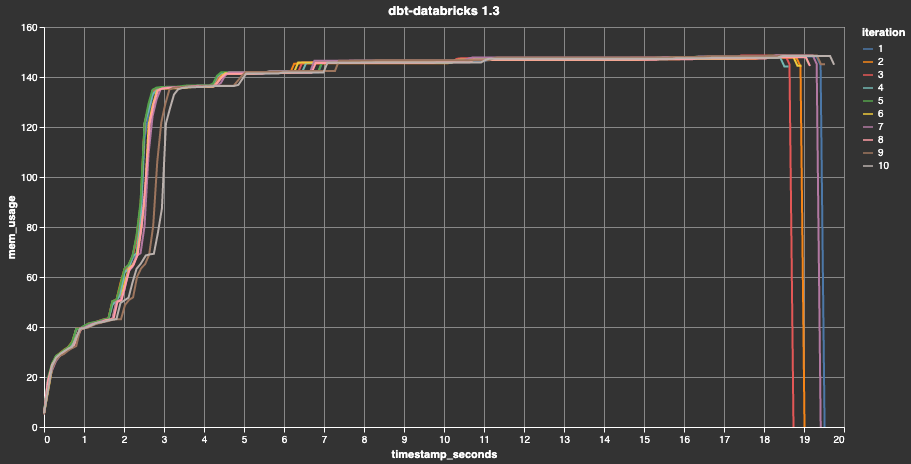

In [6]:
df = pd.DataFrame(columns=["mem_usage", "timestamp", "timestamp_seconds", "iteration"])

for _ in range(10):
    if os.path.exists(f"{cwd}/dbt/data.dat"):
        os.remove(f"{cwd}/dbt/data.dat")

    cmd = f"docker run --env-file .env -t --rm -v {cwd}/dbt:/app dbt_databricks_13 mprof run --output data.dat dbt run"
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.DEVNULL)
    p.wait()
    print(f"Run {_ + 1} completed.")
    raw = read_mprof_file(f"{cwd}/dbt/data.dat", iteration = _ + 1)
    raw_df = pd.DataFrame.from_dict(raw)
    raw_df["timestamp_seconds"] = raw_df["timestamp"] - raw_df["timestamp"][0]
    df = pd.concat([df, raw_df])

alt.Chart(df).mark_line().encode(
    x="timestamp_seconds", y="mem_usage", color="iteration:N"
).properties(
    width=800, height=400, title="dbt-databricks 1.3"
)

## 1.4.latest

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.


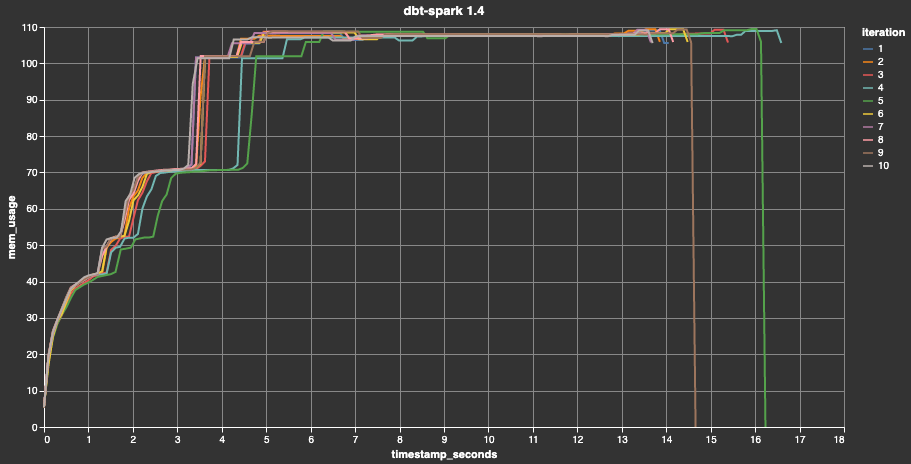

In [7]:
df = pd.DataFrame(columns=["mem_usage", "timestamp", "timestamp_seconds", "iteration"])

for _ in range(10):
    if os.path.exists(f"{cwd}/dbt/data.dat"):
        os.remove(f"{cwd}/dbt/data.dat")

    cmd = f"docker run --env-file .env -t --rm -v {cwd}/dbt:/app dbt_spark_14 mprof run --output data.dat dbt run"
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.DEVNULL)
    p.wait()
    print(f"Run {_ + 1} completed.")
    raw = read_mprof_file(f"{cwd}/dbt/data.dat", iteration = _ + 1)
    raw_df = pd.DataFrame.from_dict(raw)
    raw_df["timestamp_seconds"] = raw_df["timestamp"] - raw_df["timestamp"][0]
    df = pd.concat([df, raw_df])

alt.Chart(df).mark_line().encode(
    x="timestamp_seconds", y="mem_usage", color="iteration:N"
).properties(
    width=800, height=400, title="dbt-spark 1.4"
)

Run 1 completed.
Run 2 completed.
Run 3 completed.
Run 4 completed.
Run 5 completed.
Run 6 completed.
Run 7 completed.
Run 8 completed.
Run 9 completed.
Run 10 completed.


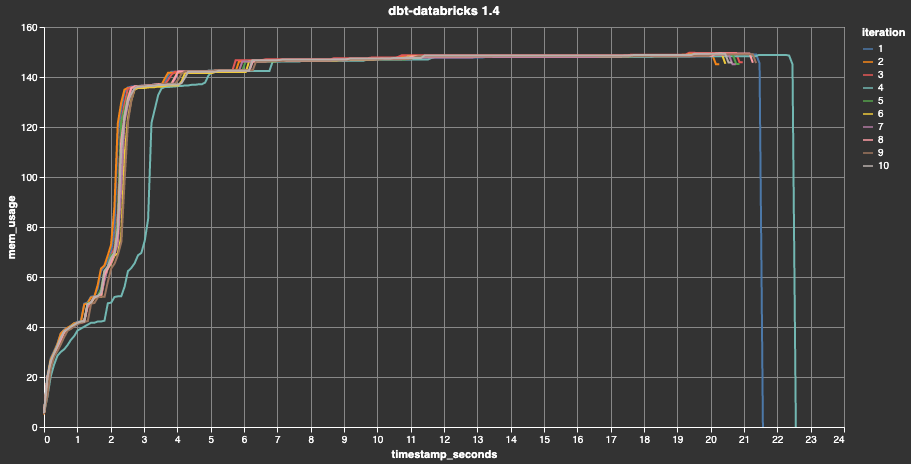

In [8]:
df = pd.DataFrame(columns=["mem_usage", "timestamp", "timestamp_seconds", "iteration"])

for _ in range(10):
    if os.path.exists(f"{cwd}/dbt/data.dat"):
        os.remove(f"{cwd}/dbt/data.dat")

    cmd = f"docker run --env-file .env -t --rm -v {cwd}/dbt:/app dbt_databricks_14 mprof run --output data.dat dbt run"
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.DEVNULL)
    p.wait()
    print(f"Run {_ + 1} completed.")
    raw = read_mprof_file(f"{cwd}/dbt/data.dat", iteration = _ + 1)
    raw_df = pd.DataFrame.from_dict(raw)
    raw_df["timestamp_seconds"] = raw_df["timestamp"] - raw_df["timestamp"][0]
    df = pd.concat([df, raw_df])

alt.Chart(df).mark_line().encode(
    x="timestamp_seconds", y="mem_usage", color="iteration:N"
).properties(
    width=800, height=400, title="dbt-databricks 1.4"
)